# Variational Autoencoders

#### Credits: lab based on practical work on Variational Autoencoders by Tudor Berariu

This practical work aims at implementing and exploring the generative capability of a simple **Variational Autoencoder**.
We analyze this behavior on hand of the MNIST dataset.

The exercises in this practical work are:
    1. Write the encoder model for a VAE - generate a mean (`loc`) and a log variance (`logvar`) parameter.
    2. Implement the _reparametrization trick_ in the forward pass of a VAE.
    3. Write the training procedure for VAE

### Imports and visualization function

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import make_grid

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
def show(img, ax=None):
    npimg = img.cpu().numpy()
    if ax is None:
      ax = plt
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

## Dataloaders

In [4]:
class DataLoader:  # pylint: disable=too-many-instance-attributes
    """ Here we implement our own vision of a DataLoader. It keeps data
        in a specified device's memory.
    """

    def __init__(  # pylint: disable=bad-continuation, too-many-arguments
        self,
        data,
        targets,
        batch_size=32,
        drop_last=False,
        shuffle=True,
        device="cpu",
        iter_device=None,
    ):
        self.__device = device = torch.device(device)
        self.__iter_device = (
            torch.device(iter_device) if iter_device else device
        )
        self.__data = data.to(device)
        self.__targets = targets.to(device)
        batch_size = int(batch_size)
        if batch_size < 1:
            self.__batch_size = len(self.__data)
        else:
            self.__batch_size = batch_size
        self.__drop_last = bool(drop_last)
        self.__shuffle = bool(shuffle)
        self.__start_idx = None
        self.__idxs = None

    @property
    def shuffle(self):
        """ True if data is shuffled for each new iterator.
        """
        return self.__shuffle

    @shuffle.setter
    def shuffle(self, value):
        self.__shuffle = bool(value)

    @property
    def batch_size(self):
        """ Returns the size of the batches.
        """
        return self.__batch_size

    @batch_size.setter
    def batch_size(self, value):
        self.__batch_size = int(value)
        if self.__batch_size < 1:
            raise ValueError("Batch size must be positive.")

    def to(self, device):  # pylint: disable=invalid-name
        """ Where the data should be stored.
        """
        self.__device = device = torch.device(device)
        self.__data = self.__data.to(device)
        self.__targets = self.__targets.to(device)
        if self.__idxs is not None:
            self.__idxs = self.__idxs.to(device)

    def iter_to(self, iter_device):  # pylint: disable=invalid-name
        """ Where the data should be stored.
        """
        self.__iter_device = iter_device = torch.device(iter_device)

    def __len__(self):
        nexamples = len(self.__data)
        full_batches = nexamples // self.batch_size
        remainder = nexamples - self.batch_size * full_batches
        if not self.__drop_last and remainder > 0:
            return full_batches + 1
        return full_batches

    def __iter__(self):
        self.__start_idx = 0
        if self.__shuffle:
            self.__idxs = torch.randperm(len(self.__data)).to(self.__device)
        else:
            self.__idxs = None
        return self

    def __next__(self):
        nexamples = len(self.__data)
        start_idx = self.__start_idx
        if start_idx >= nexamples:
            raise StopIteration

        end_idx = start_idx + self.batch_size
        if end_idx > nexamples:
            if self.__drop_last:
                raise StopIteration
            end_idx = nexamples

        if self.__shuffle:
            idxs = self.__idxs[start_idx:end_idx]
            data = self.__data[idxs]
            targets = self.__targets[idxs]
        else:
            data = self.__data[start_idx:end_idx]
            targets = self.__targets[start_idx:end_idx]

        data, targets = (
            data.to(self.__iter_device),
            targets.to(self.__iter_device),
        )

        self.__start_idx = end_idx
        return data, targets


In [5]:
def get_loaders(dataset, batch_size, device):
    """ Here we get the loaders.
    """

    if dataset not in ["MNIST", "FashionMNIST"]:
        raise NotImplementedError

    train_set = getattr(datasets, dataset)(
        f"./.data/{dataset}/", train=True, download=True
    )
    test_set = getattr(datasets, dataset)(
        f"./.data/{dataset}/", train=False, download=True
    )

    train_data = train_set.data.unsqueeze(1).float() / 255.0
    train_targets = train_set.targets
    test_data = test_set.data.unsqueeze(1).float() / 255.0
    test_targets = test_set.targets

    train_data = train_data.view(len(train_data), 1, 28, 28)
    test_data = test_data.view(len(test_data), 1, 28, 28)

    train_loader = DataLoader(
        train_data, train_targets, device=device, batch_size=batch_size
    )
    test_loader = DataLoader(
        test_data,
        test_targets,
        device=device,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, test_loader

## VAE Model

In MNIST, the images are of size `28x28`. To aid in visualization, we use a latent space of size 2.
For this practical work the _encoder_ and _decoder_ networks will be simple linear models, with ReLU or Sigmoid activations.

**TODO 1**: Write the encoder $q_{\phi}(z | x)$, for which we define the mean ($\mu$ = `loc`) and log variance($log(\sigma^2) = $`logvar`) of the modeled Gaussian distribution.

**TODO 2**: Write the _reparametrization trick_ : $z = \mu_\phi + \epsilon * \sigma_\phi$, where $\epsilon$ ~ $N(0, 1)$

In [6]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super(VAE, self).__init__()
        self.__z_size = z_size
        self.enc1 = nn.Linear(784, 512)
        self.enc2 = nn.Linear(512, 256)
        
        ## TODO 1.1
        # self.enc_loc = ... // linear Layer that brings the `mean` to the size of the latent space.
        # self.enc_logvar = ... // linear layer that brings the log variance to the size of the latent space
        
        self.enc_loc = nn.Linear(256,z_size)
        self.enc_logvar = nn.Linear(256,z_size)
        
        
        self.dec1 = nn.Linear(z_size, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, 784)

    def encode(self, x):
        ## TODO 1.2 write the two paramters - mean and log variance - that model the approximate posterior q(z|x)
        ## add ReLU activations in after enc1 and enc2 layers
        ## return a tuple consisting of the predicted mean and log variance (loc, logvar)
        
        res1 = torch.relu(self.enc1(x))
        res2 = torch.relu(self.enc2(res1))
        
        loc = self.enc_loc(res2)
        logvar = self.enc_logvar(res2)
        
        return loc, logvar
        

    def reparameterize(self, loc, logvar):
        ## TODO 2: return a z sample using the reparametrization trick
        ## your input is the the mean `loc` and the log variance - log(sigma^2), where sigma = standard deviation
        
        sigma = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(loc)
        
        res = loc + epsilon * sigma
        
        return res
        

    def decode(self, z):
        h3 = torch.relu(self.dec1(z))
        h4 = torch.relu(self.dec2(h3))
        return torch.sigmoid(self.dec3(h4))

    def forward(self, x):
        loc, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(loc, logvar)
        return self.decode(z), loc, logvar
      
    def generate(self, nsamples, device, z=None):
        with torch.no_grad():
            if z is None:
                z = torch.randn(nsamples, self.__z_size, device=device)
            return self.decode(z)

## Training the VAE

**TODO 3**: write the ELBO that we are trying to minimize for this case. Since $p(z) ~ N(0, I_2)$ (i.e. we assume a Gaussian prior for the latent space) the two terms (_reconstruction_ and _divergence_ _from_ _prior_ ) of the ELBO take the following forms:
  * $D_{KL}(q_\phi(z|x) || p(z)) = \frac{1}{2} * \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - log(\sigma_i^2) - 1)$, where `logvar`=$\sigma^2$, and $k$ is the dimensionality of the latent space 
  * rec = $E_{q_\phi(z|x)}[log p_\theta(x|z)] \approx log p_\theta(x|z)$ (i.e. since we do stochastic optimization, the expected reconstruction error is estimated through just a single sample - the current one). This means that the reconstruction error becomes the **binary cross entropy** between the output of the decoder and the true data batch (`data` in the implementation below) which was currently used to condition the generation of `z` samples.

In [7]:
#@title Experiment parameters

z_size = 2 #@param {type:"integer"}
batch_size = 64 #@param {type:"integer"}
lr = 1e-3 #@param {type:"number"}
nepochs = 15 #@param {type:"integer"}
dataset = "MNIST" #@param ["MNIST", "FashionMNIST"]
kl_coeff = 1.0 #@param {type:"number"}

Epoch   1 | KL: 288.630 | BCE: 10785.632
torch.Size([64, 784])


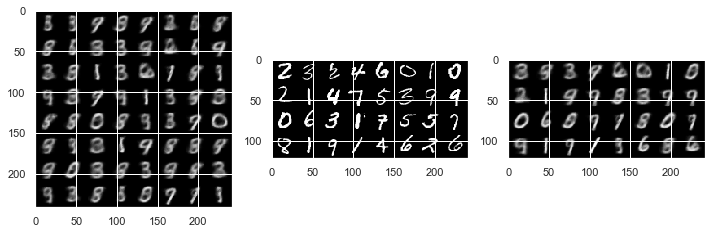

Epoch   2 done.
Epoch   2 | KL: 368.451 | BCE: 9474.279
torch.Size([64, 784])


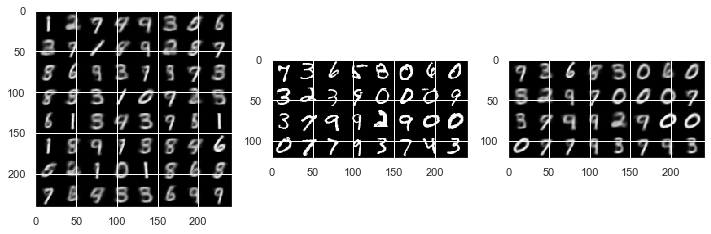

Epoch   3 done.
Epoch   3 | KL: 384.777 | BCE: 9177.688
torch.Size([64, 784])


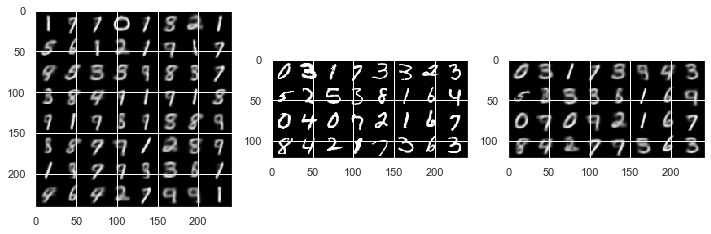

Epoch   4 done.
Epoch   4 | KL: 394.445 | BCE: 9007.107
torch.Size([64, 784])


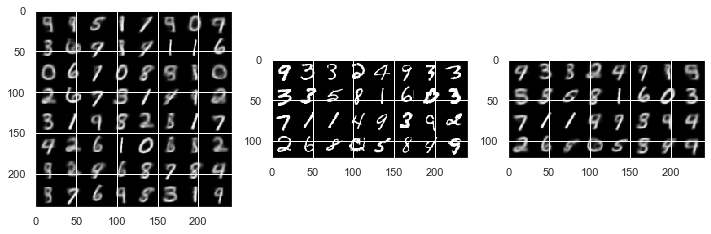

Epoch   5 done.
Epoch   5 | KL: 402.026 | BCE: 8896.946
torch.Size([64, 784])


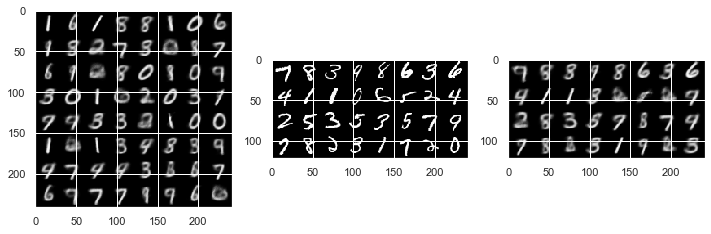

Epoch   6 done.
Epoch   6 | KL: 407.663 | BCE: 8802.728
torch.Size([64, 784])


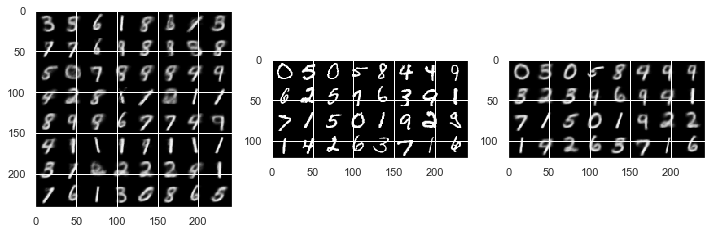

Epoch   7 done.
Epoch   7 | KL: 411.383 | BCE: 8767.477
torch.Size([64, 784])


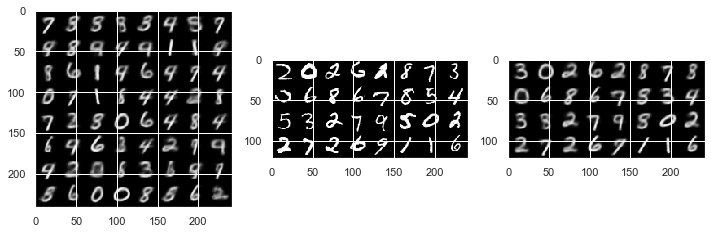

Epoch   8 done.
Epoch   8 | KL: 415.074 | BCE: 8699.861
torch.Size([64, 784])


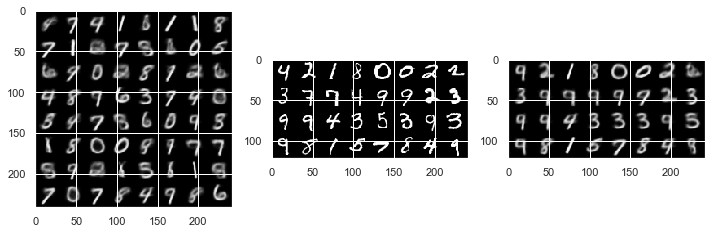

Epoch   9 done.
Epoch   9 | KL: 419.658 | BCE: 8646.299
torch.Size([64, 784])


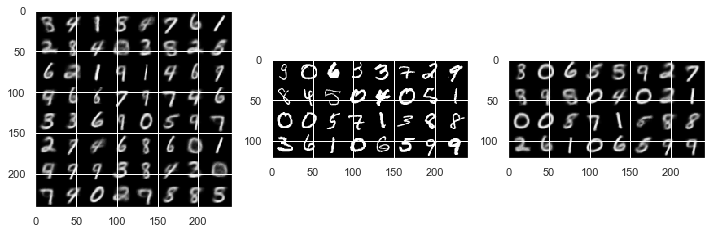

Epoch  10 done.
Epoch  10 | KL: 422.249 | BCE: 8608.246
torch.Size([64, 784])


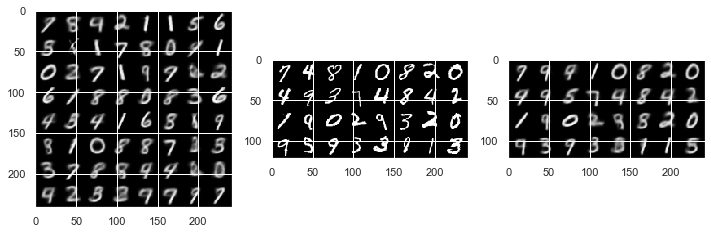

Epoch  11 done.
Epoch  11 | KL: 425.904 | BCE: 8576.762
torch.Size([64, 784])


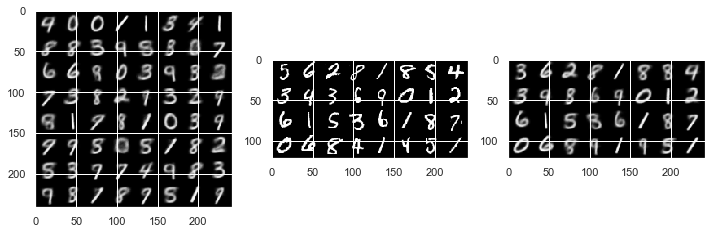

Epoch  12 done.
Epoch  12 | KL: 427.265 | BCE: 8542.549
torch.Size([64, 784])


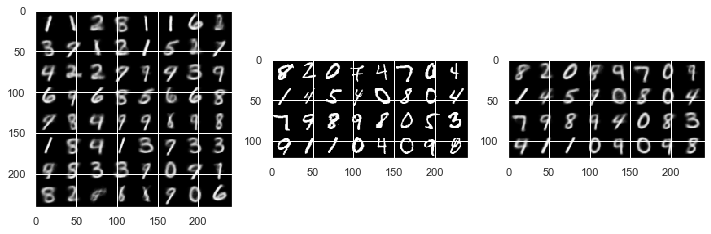

Epoch  13 done.
Epoch  13 | KL: 430.624 | BCE: 8526.699
torch.Size([64, 784])


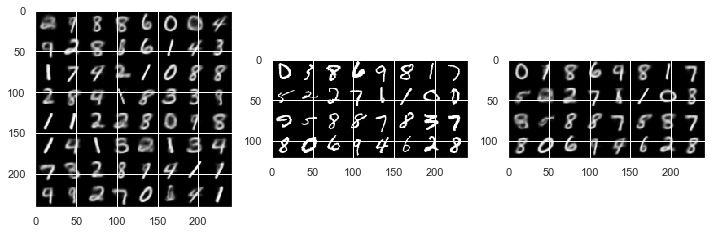

Epoch  14 done.
Epoch  14 | KL: 430.988 | BCE: 8506.467
torch.Size([64, 784])


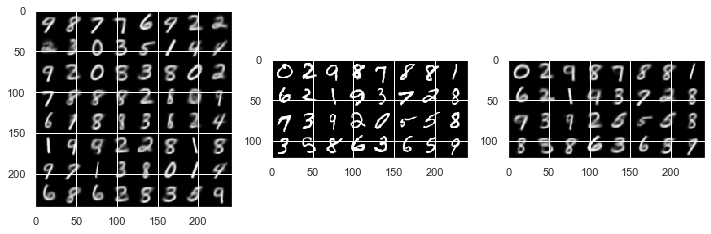

Epoch  15 done.
Epoch  15 | KL: 432.851 | BCE: 8481.764
torch.Size([64, 784])


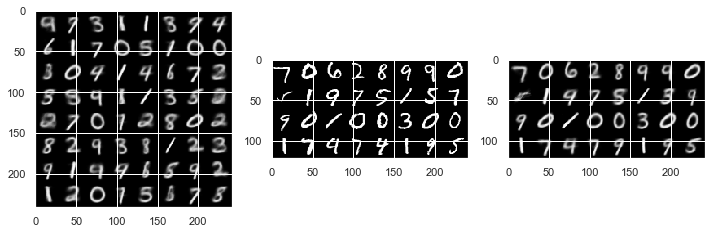

Epoch  16 done.


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_loaders(dataset, batch_size, device)
model = VAE(z_size=z_size)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

kls, bces = [], []
step = 0

for epoch in range(1, nepochs + 1):
    for data, _target in train_loader:
        data = data.view(len(data), -1)
        optimizer.zero_grad()
        output, loc, logvar = model(data)
        
        ###### TODO: define the losses: kldiv and rec
        
        kldiv, rec = None, None
        
        ## TODO 3:
        # kldiv = ... write the KL divergence term of the ELBO loss
        ## rec = ... write the reconstruction loss, where the binary cross entropy is computed between `output` and `data`
        
        kldiv = 0.5 * (torch.exp(logvar) + loc.pow(2) - logvar - 1).sum()
        
        rec = F.binary_cross_entropy(output, data, reduction="sum")
        
        ########
        
        
        loss = rec + kl_coeff * kldiv

        loss.backward()
        optimizer.step()

        kls.append(kldiv.item())
        bces.append(rec.item())

    avg_kl, avg_bce = np.mean(kls), np.mean(bces)
    print(f"Epoch {epoch:3d} | KL: {avg_kl:6.3f} | BCE: {avg_bce:6.3f}")
    kls.clear(); bces.clear()
    print(model.generate(64, device).shape)
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(ncols=3, figsize=(12, 6))
        img1 = make_grid(model.generate(64, device).view(64, 1, 28, 28))
        img2 = make_grid(output.detach().view(len(output), 1, 28, 28))
        img3 = make_grid(data.view(len(data), 1, 28, 28))
        show(img1, axs[0]); show(img3, axs[1]); show(img2, axs[2])
        plt.show()
    model.train()
    print(f"Epoch {(epoch + 1):3d} done.")

## Observing the latent space (only for bidimensional latent spaces)

After training the model, we can explore the generative capabilities of the model, by sampling over the latent space encoded by the VAE.

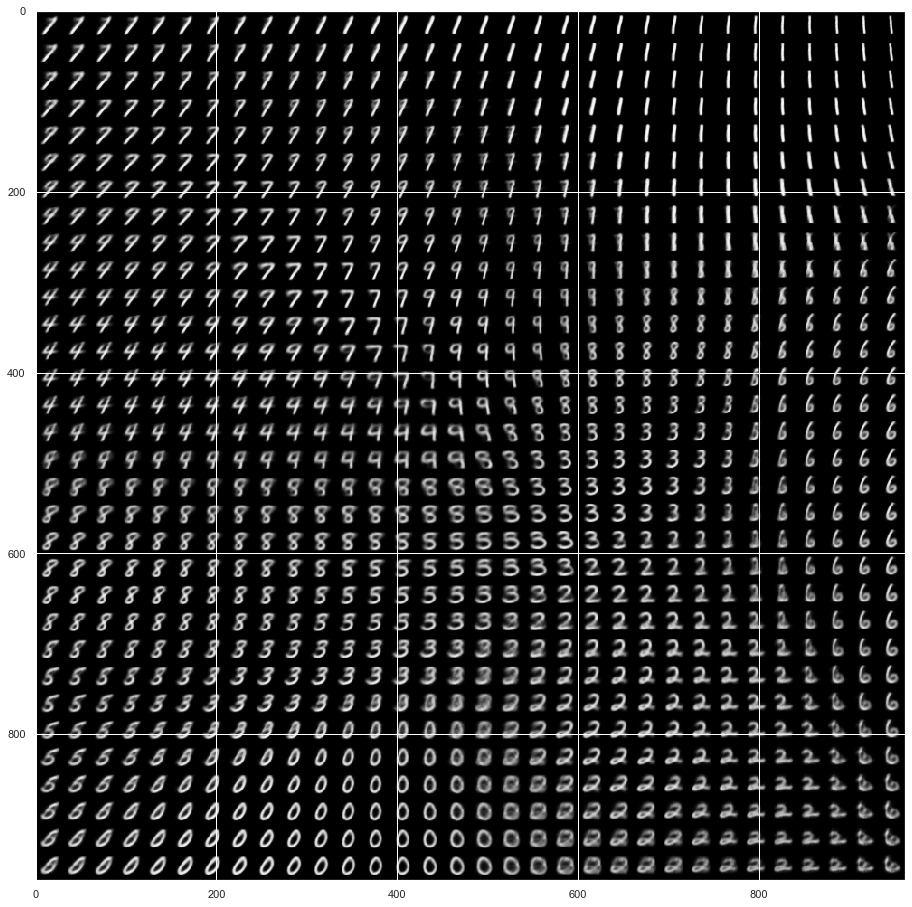

In [13]:
assert z_size == 2

lspace = torch.linspace(-1.5, 1.5, 32)
xs = lspace.view(1, 32, 1).repeat(32, 1, 1)
ys = lspace.view(32, 1, 1).repeat(1, 32, 1)
zs = torch.cat((xs, ys), dim=2).view(32 * 32, 2).to(device)
fantasies = model.generate(32 * 32, device, z=zs)
img1 = make_grid(fantasies.view(32 * 32, 1, 28, 28), nrow=32)
fig, ax = plt.subplots(figsize=(16, 16))
show(img1, ax);

## Interpolating in the latent space (it works for any z)

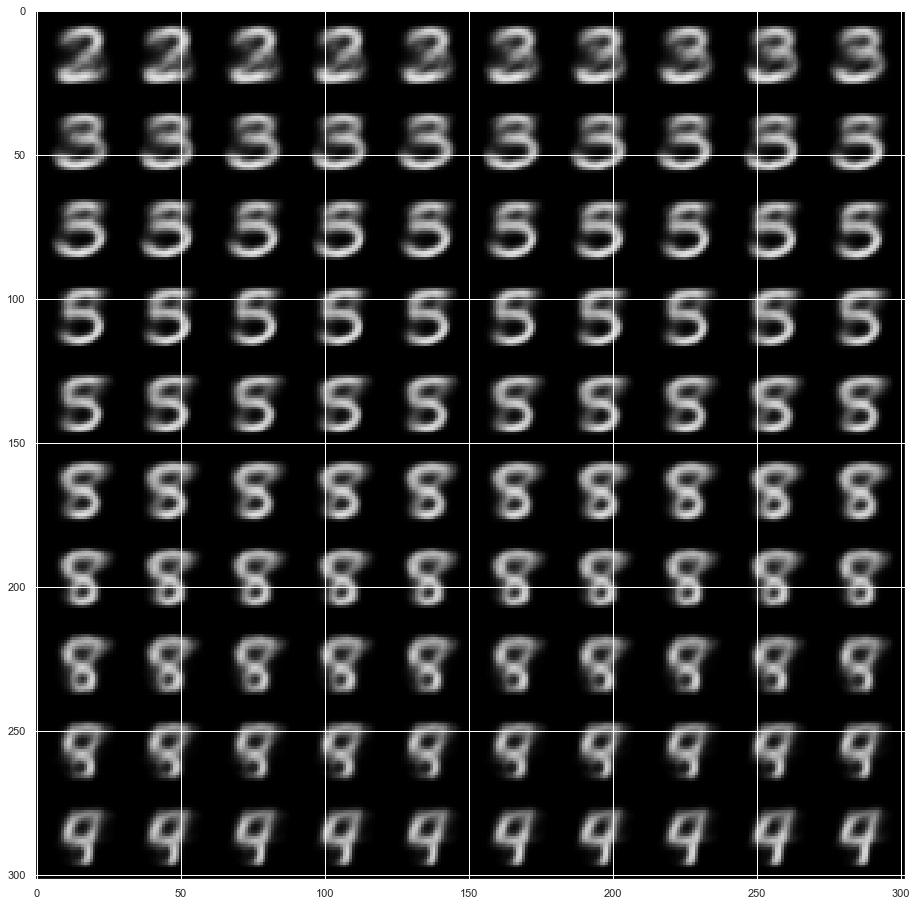

In [14]:
z1 = torch.randn((1, z_size))
z2 = torch.randn((1, z_size))

alpha = torch.linspace(0, 1, 100).view(100, 1).repeat(1, z_size)
zs = z1 * alpha + z2 * (1 - alpha)
fantasies = model.generate(10 * 10, device, z=zs.to(device))
img1 = make_grid(fantasies.view(10 * 10, 1, 28, 28), nrow=10)
fig, ax = plt.subplots(figsize=(16, 16))
show(img1, ax);

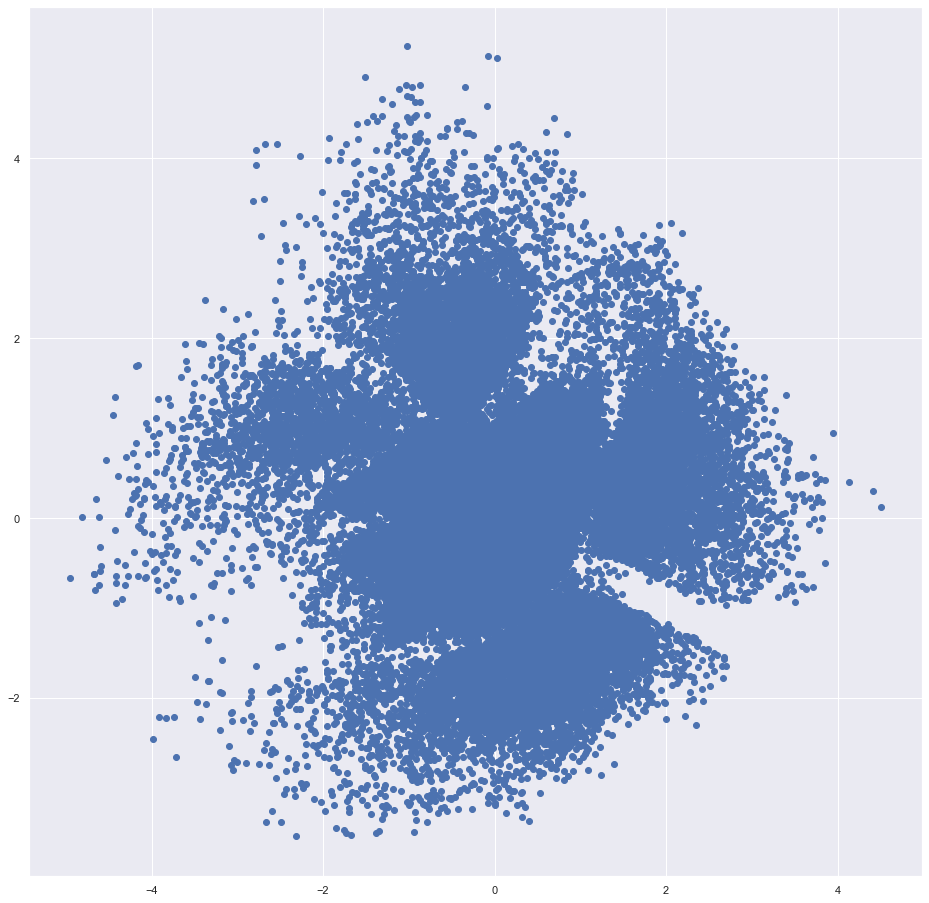

In [15]:
all_codes = torch.cat(list(model(data)[1] for data, _ in train_loader), dim=0)
np_codes = all_codes.detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(x=np_codes[:,0], y=np_codes[:, 1])